In [189]:
%reload_ext sql
%reload_ext matplotlib
# https://github.com/catherinedevlin/ipython-sql
%sql postgresql://postgres@localhost:5432/benchplatform


%config SqlMagic.feedback=False
%config SqlMagic.short_errors = True

In [196]:
#%%
import psycopg2
from ipywidgets import widgets
from ipywidgets import interactive, interact
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np 
from colour import Color # rainbow , available colour.COLOR_NAME_TO_RGB
                         # https://github.com/vaab/colour/blob/master/colour.py#L52-L192
%config SqlMagic.feedback=False
%matplotlib inline

# This plot mixes all types of benchs, it does not discriminate.
def plotRun(id,clr,title="Raw Plot"):
    
    getTarget = %sql select distinct target from bysecond_runs  where id = :id;

    getTrace = %sql select row_number() OVER(), qps FROM (select threads,sec,qps from bysecond_runs where id = :id  group by threads,sec,qps order by threads,sec asc) a;
    
    plt.plot([ r[0] for r in getTrace ],[ r[1] for r in getTrace ],clr, label=getTarget[0][0])
    plt.legend()
    plt.title('{}'.format(title))
    plt.ylabel("Tx/s")
    plt.xlabel("Time Secs")
    return plt
    
def plotRunByThreads(id,between,bucket=5,btype="5050",colour="green"):
    rainbow = {}
    getTarget  = %sql SELECT distinct target from bysecond_runs WHERE id = :id;
    getThreads = %sql SELECT distinct threads FROM bysecond_runs WHERE id = :id and threads % 50 = 0 and threads between {between} ORDER BY threads DESC;  
    getAllThreads = %sql SELECT distinct threads FROM bysecond_runs WHERE id = :id and threads between {between} ORDER BY threads ASC;
    
    red = Color('white') 
    colorpick = Color(colour)
    thlen = len(getThreads)
    rclr = list( [c.get_rgb() for c in colorpick.range_to(red,thlen*3) ] )

    for th,clr in zip(getThreads,rclr[:thlen]):
        rainbow[th[0]] = clr 
    
    xoffset = 0
    for thread in getThreads:   
        thd = thread[0] 
        
        # This query ignores threads that aren't module of the step variable in the benchmarks.
        # The above won't be ignored and it will be graphed in a different function, marking the
        # entries with threads lower than the expected. It won't be unexpected to see more delay on
        # setting up the connection in Postgres and Pgbouncer[1]. 
        # [1] Although the numbers supports that improves throughput thanks to less spinning times,
        # the benchmarks won't take advantage of this, as these pools are better in conditions wheter
        # connections varies constantly. Otherwise, it just behaves as connecting to database directly.
        ts_threads = """
            WITH bysecAgg AS (
                select 
                  sec,
                  qps,
                  avg(qps) OVER () as av,
                  max(qps) OVER () as mx,
                  stddev(qps::double precision) OVER () as sdev,
                  avg(qps) OVER (PARTITION BY round(sec/{})) as secBucketQpsAvg
                from bysecond_runs 
                where id = '{}' and threads = {} and type = '{}' and node ~ 'client.*-1'
                group by sec,qps 
                order by sec asc
            ), bysec AS (
                select row_number() OVER () as xoffset, 
                    qps, 
                    round(av) as av,
                    mx as mx,
                    round(sdev) as sdev, 
                    round(secBucketQpsAvg) as secBucketQpsAvg
                    FROM bysecAgg
            )
            SELECT xoffset,qps, av,mx,sdev,secBucketQpsAvg, max(xoffset) OVER ()
            FROM bysec 
            
            ;
        """.format(bucket,id,thd,btype)
        getTrace = %sql $ts_threads
        av = getTrace[0][2]
        mx  = getTrace[0][3]
        sdev = getTrace[0][4]
        target = getTarget[0][0]
        #plt.subplot()
        plt.plot([ r[0]+xoffset for r in getTrace ],[ r[5] for r in getTrace ],
                 color=rainbow[thd],
                label="{}: {} - {} - {} - {}".format(target,thd,av,mx,sdev))
        xoffset = xoffset + getTrace[0][6]
        
        #ax = plt.subplot()
        plt.legend()
    plt.ylabel("Q-E/s")
    plt.xlabel("Time (secs)")
    return plt

    
def plotSarLoadAvg(id, colour="green"):
    whiter = Color('white') 
    colorpick = Color(colour)
    rclr = list( [c.get_rgb() for c in colorpick.range_to(whiter,3*3) ] )
    
    getTarget = %sql SELECT distinct target from sar_load_avg where id = :id;
    tsSQL = """
        SELECT  stamp , runq_size,plist_size , load_avg_1 , load_avg_5, load_avg_15 , blocked 
        FROM sar_load_avg
        WHERE id = '{}'
        ORDER BY stamp ASC
    """.format(id)    
    getTS     = %sql $tsSQL
    #ax = plt.subplot()
    min1avg = [ np.mean(r[3]) for r in getTS ]
    min5avg = [ np.mean(r[4]) for r in getTS ]
    plt.plot([ r[0] for r in getTS ],[ r[3] for r in getTS ], color=rclr[0],label="1 min ".format(min1avg) )
    plt.plot([ r[0] for r in getTS ],[ r[4] for r in getTS ], color=rclr[2],label="5 min ".format(min5avg) )
    plt.plot([ r[0] for r in getTS ],[ r[5] for r in getTS ], color=rclr[4],label="15 min ".format(min1avg) )

    plt.legend()
    plt.title("Load Avg - {}".format(getTarget[0][0]))
    plt.ylabel("Load Avg")
    plt.xlabel("Time")
    return plt 


def plotSarCS(id, colour="green"):
    getTarget = %sql SELECT distinct target from sar_load_avg where id = :id;
    tsSQL = """
        SELECT  stamp , processes_per_second , cs_per_second
        FROM sar_context_switches
        WHERE id = '{}'
        ORDER BY stamp ASC
    """.format(id)    
    getTS     = %sql $tsSQL
    #ax = plt.subplot()
    plt.plot([ r[0] for r in getTS ],[ r[1] for r in getTS ], color=colour,label="{}".format(getTarget[0][0]) )
    plt.legend()
    plt.ylabel("CS")
    plt.xlabel("Time")
    return plt 


 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform


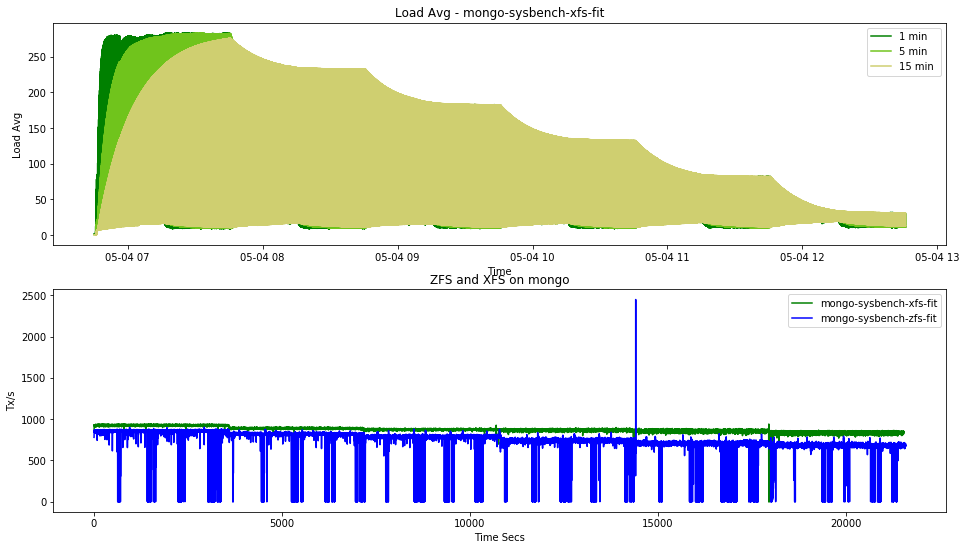

In [197]:
%matplotlib inline

# DEPRECATED in favor of per thread discrimination plotRunByThreads,
# use plotRun only for validation or exploration

# MONGO FIT

plt.rcParams["figure.figsize"] = [16,9]
plt.subplot(211)
plotSarLoadAvg('bc0abe95-3652-f7b9-a829-cb7c4a6b4304','green')

plt.subplot(212)
plotRun('bc0abe95-3652-f7b9-a829-cb7c4a6b4304','green') # xfs
plotRun('be4af4dd-bbe1-0ca5-aeb4-13118611b3ba', 'blue',title='ZFS and XFS on mongo') # zfs

plt.show()

# PGBOUNCER FIT
#pltpgb = plotRun('4ca4ab12-2ab3-9407-2495-efb0aa13835e','yellow') # xfs
#pltpgb = plotRun('f1f7b29a-ebe8-1997-a00c-8df20b848752', 'red') # zfs
#pltpgb.rcParams["figure.figsize"] = [16,9]
#pltpgb.show()
# POSTGRES FIT
#pltpo = plotRun('874c34e2-a81f-6e02-4dc5-6921faf8881d','brown') # xfs
#pltpo = plotRun('e1e8fa66-d6aa-42b1-ef30-62c0928cec27', 'black') # zfs
#pltpo.rcParams["figure.figsize"] = [16,9]
#pltpo.show()

# MONGO XL
#pltmongoxl = plotRun('8a32b055-1220-ff7b-be8f-07ddd03c8315','green') # xfs
#pltmongoxl = plotRun('8c8c92e2-199c-0f21-d529-7600ab56f07d', 'blue') # zfs
#pltmongoxl.show()

# PGBOUNCER XL
#pltpgbxl = plotRun('4ff865c6-06a1-9508-65e6-f30891e64124','yellow') # xfs
#pltpgbxl = plotRun('a3e684aa-1308-ab49-b78b-749e2e679006', 'red') # zfs
#pltpgbxl.show()

# POSTGRES XL
#pltpoxl = plotRun('50280e3d-52f6-3dc5-7cfe-73ac767b0f89','brown') # xfs
#pltpoxl = plotRun('4a4691b4-2ffb-db97-29fe-260c97349512', 'black') # zfs
#pltpoxl.show()



 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

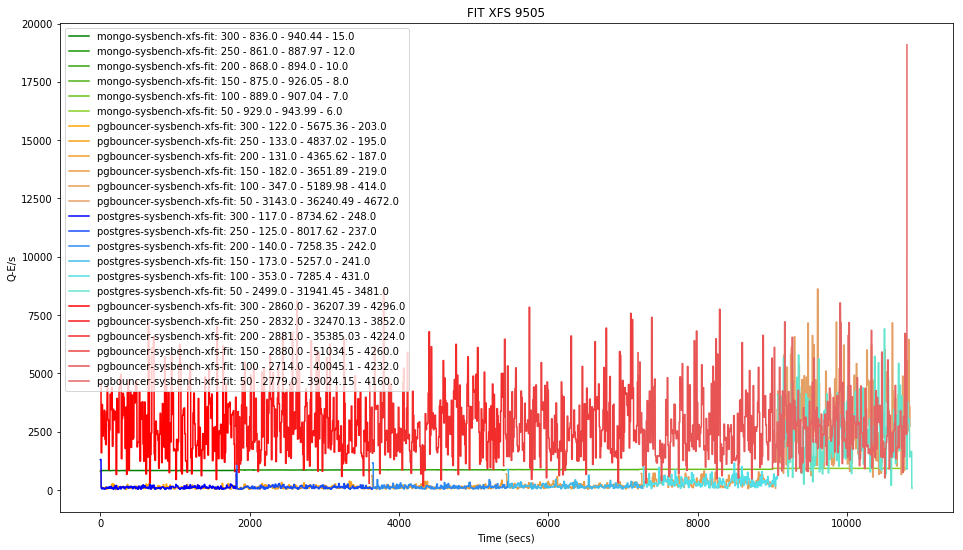

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

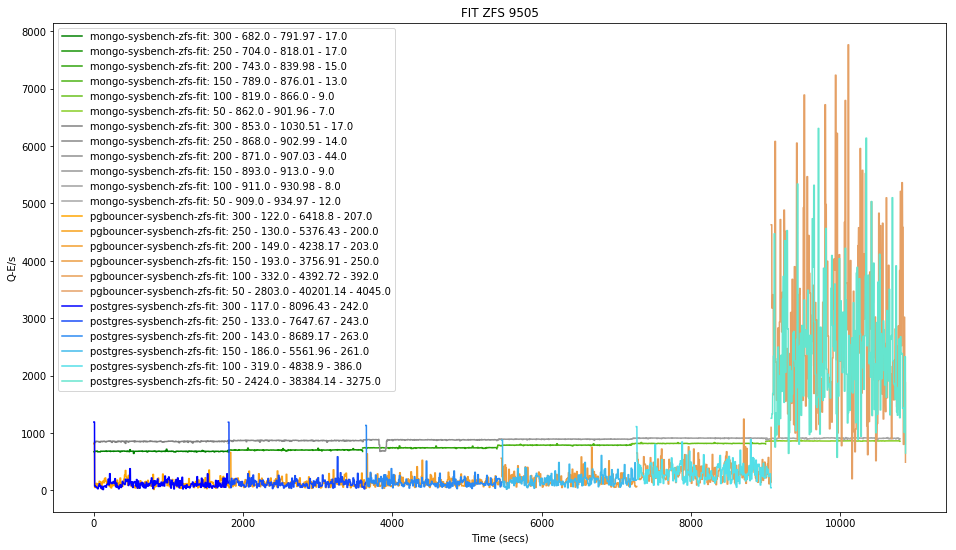

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

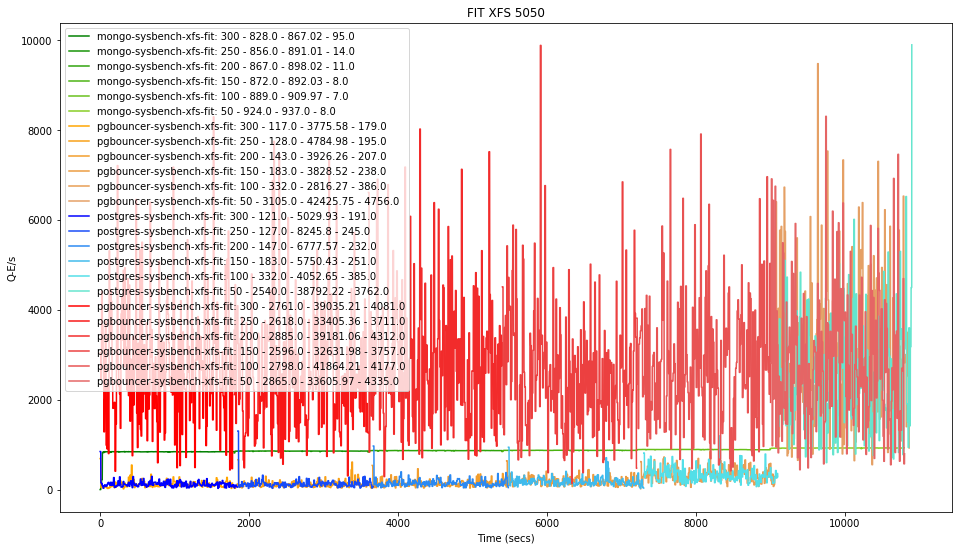

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

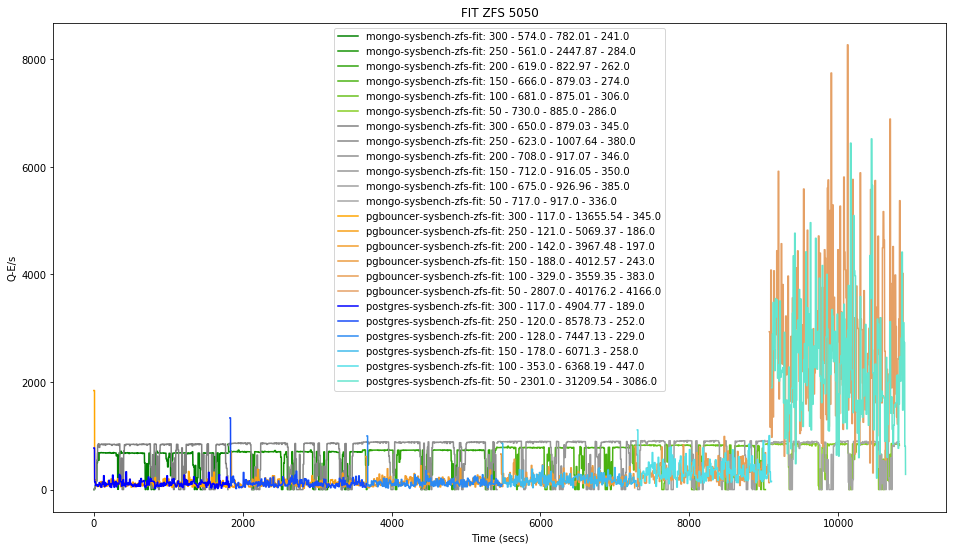

In [25]:
#%% 
# Plot by threads (5050 by default)


#  FIT XFS 9505
pltxfsfit = plotRunByThreads('bc0abe95-3652-f7b9-a829-cb7c4a6b4304','0 and 1000',10,'9505', colour="green") # xfs
pltxfsfit = plotRunByThreads('4ca4ab12-2ab3-9407-2495-efb0aa13835e','0 and 1000',10,'9505', colour="orange") # xfs
pltxfsfit = plotRunByThreads('874c34e2-a81f-6e02-4dc5-6921faf8881d','0 and 1000',10,'9505', colour="blue") # xfs
pltxfsfit = plotRunByThreads('5352972d-85c4-f6e5-db92-2bfa723f33c1','0 and 1000',10,'9505', colour="red") # xfs


pltxfsfit.rcParams["figure.figsize"] = [16,9]
pltxfsfit.title("FIT XFS 9505")
pltxfsfit.show()

# FIT ZFS
pltzfsfit = plotRunByThreads('be4af4dd-bbe1-0ca5-aeb4-13118611b3ba','0 and 1000',10,'9505', colour="green") # zfs
pltzfsfit = plotRunByThreads('c9099a54-da70-fe1b-61e7-2c7f8d88d10a','0 and 1000',10,'9505', colour="grey") # zfs

pltzfsfit = plotRunByThreads('f1f7b29a-ebe8-1997-a00c-8df20b848752','0 and 1000',10,'9505', colour="orange") # zfs
pltzfsfit = plotRunByThreads('e1e8fa66-d6aa-42b1-ef30-62c0928cec27','0 and 1000',10,'9505', colour="blue") # zfs
pltzfsfit.rcParams["figure.figsize"] = [16,9]
pltzfsfit.title("FIT ZFS 9505")
pltzfsfit.show() 

#  FIT XFS 5050
pltxfsfit = plotRunByThreads('bc0abe95-3652-f7b9-a829-cb7c4a6b4304','0 and 1000',10,'5050', colour="green") # xfs
pltxfsfit = plotRunByThreads('4ca4ab12-2ab3-9407-2495-efb0aa13835e','0 and 1000',10,'5050', colour="orange") # xfs
pltxfsfit = plotRunByThreads('874c34e2-a81f-6e02-4dc5-6921faf8881d','0 and 1000',10,'5050', colour="blue") # xfs
pltxfsfit = plotRunByThreads('5352972d-85c4-f6e5-db92-2bfa723f33c1','0 and 1000',10,'5050', colour="red") # xfs

pltxfsfit.rcParams["figure.figsize"] = [16,9]
pltxfsfit.title("FIT XFS 5050")
pltxfsfit.show()

# FIT ZFS
pltzfsfit = plotRunByThreads('be4af4dd-bbe1-0ca5-aeb4-13118611b3ba','0 and 1000',10,'5050', colour="green") # zfs
pltzfsfit = plotRunByThreads('c9099a54-da70-fe1b-61e7-2c7f8d88d10a','0 and 1000',10,'5050', colour="grey") # zfs
pltzfsfit = plotRunByThreads('f1f7b29a-ebe8-1997-a00c-8df20b848752','0 and 1000',10,'5050', colour="orange") # zfs
pltzfsfit = plotRunByThreads('e1e8fa66-d6aa-42b1-ef30-62c0928cec27','0 and 1000',10,'5050', colour="blue") # zfs
pltzfsfit.rcParams["figure.figsize"] = [16,9]
pltzfsfit.title("FIT ZFS 5050")
pltzfsfit.show() 



 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

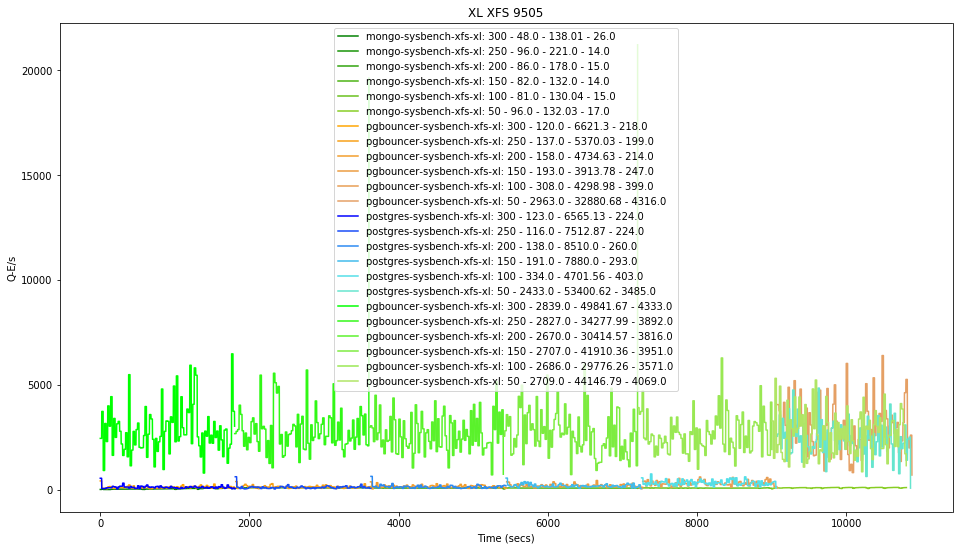

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

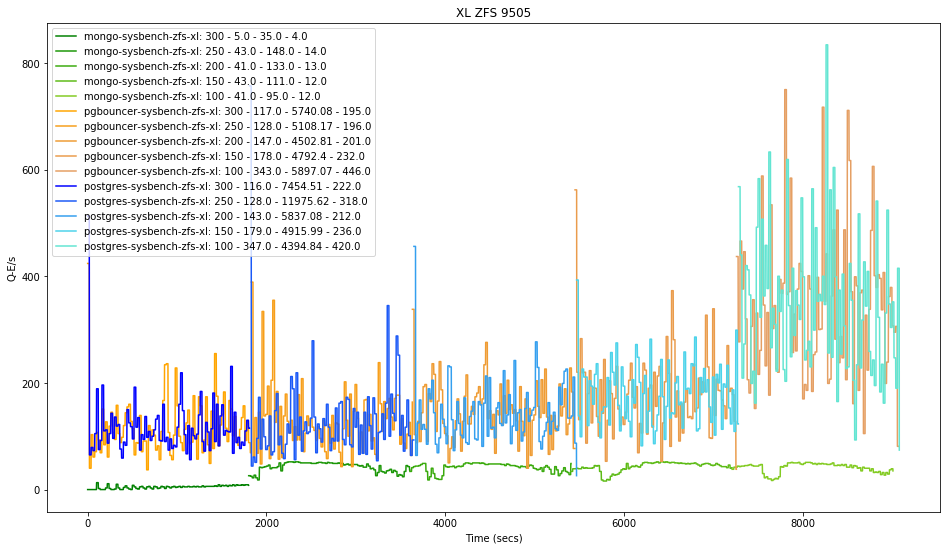

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

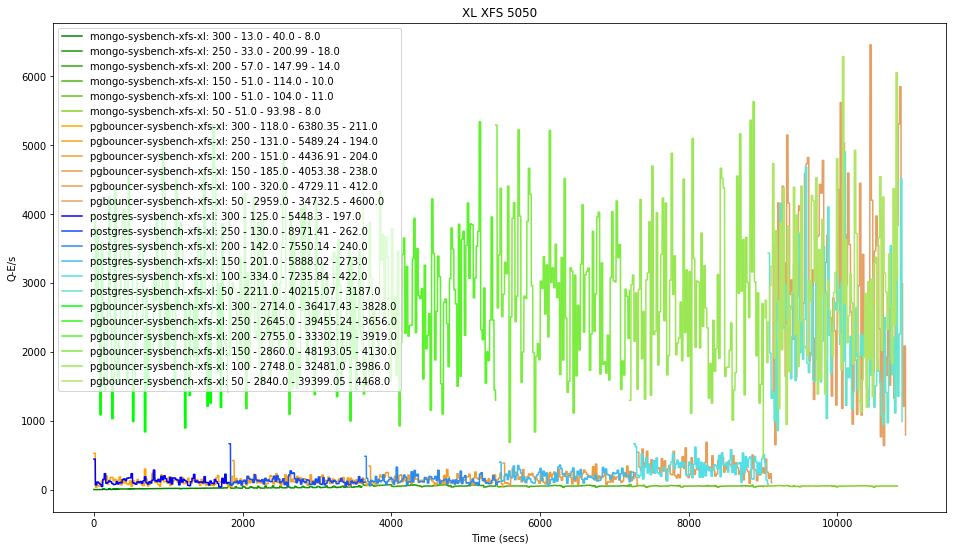

 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@localhost:5432/benchplatform
 * postgresql://postgres@loc

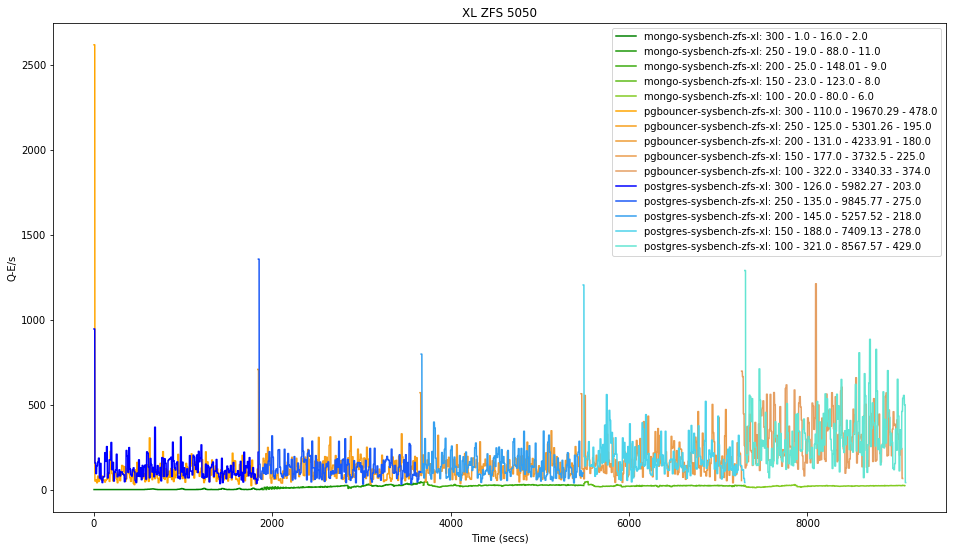

In [9]:


pltxfsxl = plotRunByThreads('8a32b055-1220-ff7b-be8f-07ddd03c8315','0 and 1000',20,'9505', colour="green") # xfs
pltxfsxl = plotRunByThreads('4ff865c6-06a1-9508-65e6-f30891e64124','0 and 1000',20,'9505', colour="orange") # xfs
pltxfsxl = plotRunByThreads('50280e3d-52f6-3dc5-7cfe-73ac767b0f89','0 and 1000',20,'9505', colour="blue") # xfs
pltxfsxl = plotRunByThreads('7f5cf022-085c-f237-2fa4-4f5e8836155e','0 and 1000',20,'9505', colour="lime") # xfs

pltxfsxl.rcParams["figure.figsize"] = [16,9]
pltxfsxl.title("XL XFS 9505")
pltxfsxl.show() 


pltzfsxl = plotRunByThreads('8c8c92e2-199c-0f21-d529-7600ab56f07d','51 and 1000',20,'9505', colour="green") # zfs
pltzfsxl = plotRunByThreads('a3e684aa-1308-ab49-b78b-749e2e679006','51 and 1000',20,'9505', colour="orange") # zfs
pltzfsxl = plotRunByThreads('4a4691b4-2ffb-db97-29fe-260c97349512','51 and 1000',20,'9505', colour="blue") # zfs
pltzfsxl.rcParams["figure.figsize"] = [16,9]
pltzfsxl.title("XL ZFS 9505")
pltzfsxl.show()


pltxfsxl = plotRunByThreads('8a32b055-1220-ff7b-be8f-07ddd03c8315','0 and 1000',20,'5050', colour="green") # xfs
pltxfsxl = plotRunByThreads('4ff865c6-06a1-9508-65e6-f30891e64124','0 and 1000',20,'5050', colour="orange") # xfs
pltxfsxl = plotRunByThreads('50280e3d-52f6-3dc5-7cfe-73ac767b0f89','0 and 1000',20,'5050', colour="blue") # xfs
pltxfsxl = plotRunByThreads('7f5cf022-085c-f237-2fa4-4f5e8836155e','0 and 1000',20,'5050', colour="lime") # xfs

pltxfsxl.rcParams["figure.figsize"] = [16,9]
pltxfsxl.title("XL XFS 5050")
pltxfsxl.show() 


pltzfsxl = plotRunByThreads('8c8c92e2-199c-0f21-d529-7600ab56f07d','51 and 1000',10,'5050', colour="green") # zfs
pltzfsxl = plotRunByThreads('a3e684aa-1308-ab49-b78b-749e2e679006','51 and 1000',10,'5050', colour="orange") # zfs
pltzfsxl = plotRunByThreads('4a4691b4-2ffb-db97-29fe-260c97349512','51 and 1000',10,'5050', colour="blue") # zfs
pltzfsxl.rcParams["figure.figsize"] = [16,9]
pltzfsxl.title("XL ZFS 5050")
pltzfsxl.show() 

In [1]:
#%%
import psycopg2
from ipywidgets import widgets
from ipywidgets import interactive, interact
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np 

dburl="postgresql://postgres@localhost:5432/benchplatform"
client = psycopg2.connect(dburl)
cur = client.cursor()

sql_targets ="""
    select distinct target 
    from bysecond_runs
    where target like '{}' and type like '{}'
    order by 1
"""
sql_threads ="""
    SELECT DISTINCT threads 
    FROM bysecond_runs
    WHERE threads % 50 = 0  and threads > {} 
    -- step is 50 in benchmarks
"""
sql_arange ="""
    SELECT min(qps), max(qps) FROM bysecond_runs
"""

sql_getall = """
    select target,id, type, threads, round(avg(qps)) avg_qps,round(max(qps)) max_qps ,
    round(min(qps)) min_qps,round(stddev(qps)) sdv_qps 
    from bysecond_runs 
    where threads % 50  = 0 and target like '{}' and type like '{}'
    group by target, id,type, threads order by threads
"""

sqlAggregateAll = """
    select target,type, threads, round(avg(qps)) avg_qps,round(max(qps)) max_qps ,
    round(min(qps)) min_qps,round(stddev(qps)) sdv_qps 
    from bysecond_runs 
    where threads % 50  = 0 and target like '{}' and type like '{}'
    group by target, type, threads order by threads
"""

sqlAggregateAllThreads = """
    select threads, target,type, round(avg(qps)),round(stddev(qps)) sdv_qps
    from bysecond_runs 
    where threads = {} and target like '{}' and type like '{}'
    group by threads, target, type order by threads, target
"""
#,round(stddev(tps)) sdv_qps

sqlAggQPSbyTarget = """
    select round(avg(qps)) 
    from bysecond_runs 
    where threads = {}
       and target = '{}' and type like '{}'
    group by target
    order by target
"""


# https://matplotlib.org/gallery/misc/table_demo.html


def plotTable(filter, btype, excludeThreads):
    plt.clf()
    # Get columns
    cur.execute(sql_targets.format(filter,btype))
    columns = [r[0] for r in cur]
    
    cur.execute(sql_threads.format(excludeThreads))
    rows = [r[0] for r in cur.fetchall()]
    rowLabels = ['{} threads'.format(r) for r in rows]

    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

    cur.execute(sql_arange)
    (minval,maxval) = [r for r in cur.fetchone()]
    values = np.arange(minval,maxval) #,5000)
    value_increment = 1000 ## Not sure if will be used

    #cur.execute(sqlAggregateAll.format(filter,btype))
    #res = [r for r in cur.fetchall()]
    
    n_rows = len(rows)
    index = np.arange(len(columns)) + 0.1 #* 50  #np.arange(len(columns)) #+ 0.3
    y_offset = np.zeros(len(columns))
    bar_width = 0.3
        

    #plt.title('Plot with filtering for {} and {}'.format(filter,btype))
    
    cell_text = []
    qps = {}
    ste = {}
    cr = 0    
    for th in rows:
        qps[th] = []
        ste[th] = []
        for tgt in columns:
            cur.execute(sqlAggQPSbyTarget.format(th,tgt,btype))
            for r in cur.fetchall():
                qps[th].append(r[0])
                #ste[th].append(r[1])  
        #yerr=ste[th],
        plt.bar(index, qps[th],  bar_width, bottom=y_offset,color = colors[cr])
        y_offset = y_offset + qps[th]
        cell_text.append(['%1.1f' % (x) for x in y_offset])
        cr +=  1
    
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()

    
    the_table = plt.table(cellText=cell_text,
                      rowLabels=rowLabels,
                      rowColours=colors,
                      colLabels=columns,
                      fontsize=50,
                      loc='bottom')
    # Adjust layout to make room for the table:
    #plt.subplots_adjust(left=0.4, bottom=0.4)
    #plt.ylabel("QPS/EPS ${0}'s".format(value_increment))

    #plt.yticks(values * value_increment, ['%d' % val for val in values])
    #plt.xticks([])
    
    #plt.rcParams['figure.figsize'] = [120, 80]

    plt.show()

    #widgets.SelectMultiple(
    #    options=options,
    #    description='Targets:',
    #    disabled=False
    #)

#interact(plotTable, filter='%xl%',btype='5050', excludeThreads='0')


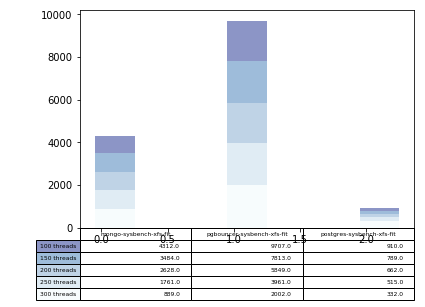

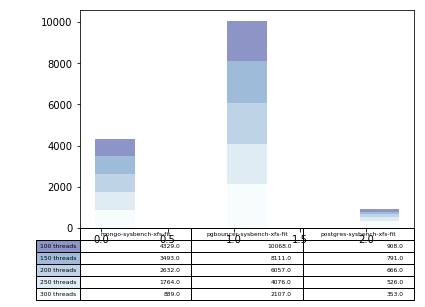

In [2]:
#print("XFS FIT")
plotTable(filter='%xfs-fit%',btype='5050', excludeThreads='51')
plotTable(filter='%xfs-fit%',btype='9505', excludeThreads='51')

In [468]:
#print("XFS XL")
#plotTable(filter='%xfs-xl%',btype='5050', excludeThreads='51')
#plotTable(filter='%xfs-xl%',btype='9505', excludeThreads='51')


In [469]:
#print("ZFS FIT")
#plotTable(filter='%xfs-fit%',btype='5050', excludeThreads='51')
#plotTable(filter='%xfs-fit%',btype='9505', excludeThreads='51')
#print("ZFS XL")
#plotTable(filter='%zfs-xl%',btype='5050', excludeThreads='51')
#plotTable(filter='%zfs-xl%',btype='9505', excludeThreads='51')